<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Краткий-вывод" data-toc-modified-id="Краткий-вывод-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Краткий вывод</a></span></li><li><span><a href="#Подготовка-данных-к-обучению-моделей" data-toc-modified-id="Подготовка-данных-к-обучению-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных к обучению моделей</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Краткий-вывод" data-toc-modified-id="Краткий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Краткий вывод</a></span><ul class="toc-item"><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке</a></span></li><li><span><a href="#Краткий-вывод" data-toc-modified-id="Краткий-вывод-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Краткий вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Imports
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import numpy as np
import os
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

import torch
import transformers
from tqdm import notebook


# Seed

RS = 4613

# Parameters

pd.options.display.max_colwidth = 300
plt.rcParams["figure.figsize"] = (12, 8)

In [2]:
pth1 = 'D:\Temp\Ya_Pr\toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0])
elif not os.path.exists(pth1):
    data = pd.read_csv('https://code.s3.yandex.net//datasets//toxic_comments.csv', index_col=[0])
else:
    print('Something is wrong')

data.head()

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no...",0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [3]:
data.duplicated().sum()

0

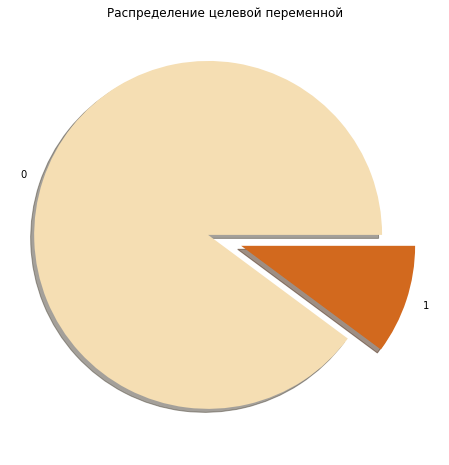

In [4]:
plt.pie(data['toxic'].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)

plt.title('Распределение целевой переменной');

Итак, явных дубликатов в данных нет.  
Виден дисбаланс по целевой переменной (~9:1).

Далее почистим текст 

In [5]:
nltk.download('punkt')

nltk.download('wordnet')

nltk.download('stopwords')

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\apple\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
def cleaner(text):
    
    text = text.lower()
    text = re.sub(r'[^a-z ]', ' ', text )
    text = ' '.join(text.split())
    
    
    return text


In [8]:
def get_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
mystem2 = WordNetLemmatizer()

def lemmer(texts):
    text = cleaner(texts)
    text = word_tokenize(text)
    text = [word for word in text if word.lower() not in stops]

    text = [mystem2.lemmatize(word, get_pos(word)) for word in text]
    return ' '.join(text)

In [10]:
stops = set(nltk_stopwords.words('english'))


tqdm.pandas()
data['lemm_text'] = data['text'].progress_apply(lemmer)
data.sample(10)


100%|██████████| 159292/159292 [31:30<00:00, 84.25it/s] 


,text,toxic,lemm_text
63374,"Ah, you're correct - it was Political postions, not this article. My error. ?!?",0,ah correct political postions article error
2797,Language(s) \n\nPlease do not contribute text in Slovenian to English Wikipedia. Your contributions are more than welcome at the Slovenian Wikipedia.-,0,language please contribute text slovenian english wikipedia contribution welcome slovenian wikipedia
143594,""":I concur with the The Elements of Style and N5iln, the possessive should be """"Jobs's"""" \n\n""",0,concur element style n iln possessive job
56600,""" while claiming, """"Rather than pick and choose ... which opinions ... we should insert in this article, we should not be inserting any"""" """,0,claim rather pick choose opinion insert article insert
79965,Removed self-reference on function \n\nJust wanted to drop you a quick courtesy note to let you know I reverted your addition of the (t),0,remove self reference function want drop quick courtesy note let know revert addition
82098,I wonder if Wright's house is a tourist attraction like Johnny Adair's?,0,wonder wright house tourist attraction like johnny adair
88190,"Blocks \n\nOh and by the way, she had already blocked me for no apparent reason right before I typed that out of anger. Why do you think I was so angry at her.",0,block oh way already block apparent reason right typed anger think angry
48768,grow up \n\nGet a life,0,grow get life
133954,"""\n\nThis message is regarding the page User:Jpgordon. Please stop. If you continue to vandalize pages, you will be blocked from editing Wikipedia. «»?¿?meta """,0,message regard page user jpgordon please stop continue vandalize page block edit wikipedia meta
15494,"""\n\n About . \n\nI already e-mailed this report on . I hope that someone of serious Wikipedia administrators will read this report and take serious steps in protecting the Wikipedia dignity\n\nHello,\n\nI do understand that Wikipedia is a free encyclopaedia - but still some kind of very basic ...",0,already e mail report hope someone serious wikipedia administrator read report take serious step protect wikipedia dignity hello understand wikipedia free encyclopaedia still kind basic ethicalrules shall applicable oblige editor notice person whose nick name http en wikipedia org wiki user spyl...


In [11]:

text = str([''.join(string) for string in data['lemm_text']])

text_tokens = word_tokenize(cleaner(text))

fdist = FreqDist(text_tokens)

In [12]:
top_words = fdist.most_common(15)

word_for_plot = {}

for i in top_words:
    word_for_plot[i[0]] = i[1]

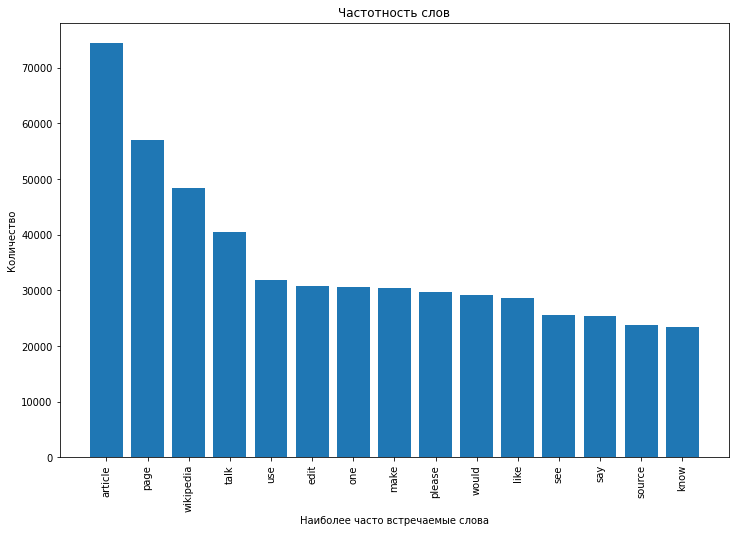

In [13]:

plt.title('Частотность слов')
plt.xlabel('Наиболее часто встречаемые слова')
plt.xticks(rotation=90)
plt.ylabel('Количество')

plt.bar(word_for_plot.keys(), word_for_plot.values())

plt.show()

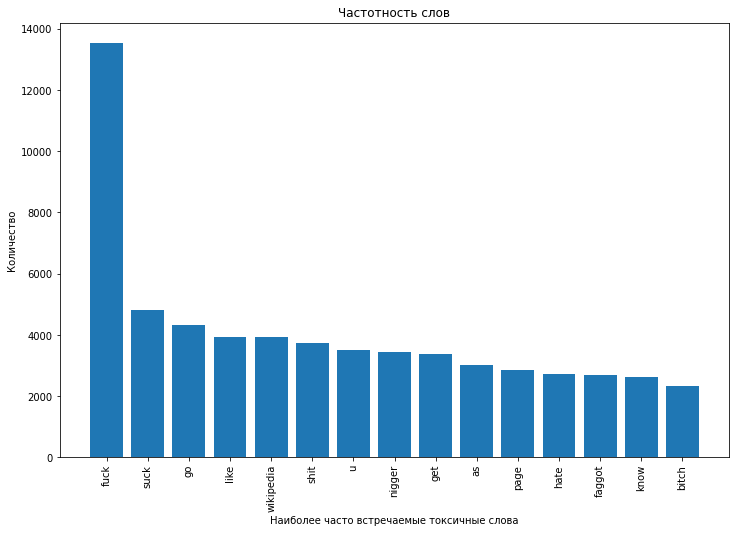

In [14]:

text = str([''.join(string) for string in data[data['toxic'] == 1]['lemm_text']])

text_tokens = word_tokenize(cleaner(text))

fdist = FreqDist(text_tokens)

top_words = fdist.most_common(15)

word_for_plot = {}

for i in top_words:
    word_for_plot[i[0]] = i[1]


plt.title('Частотность слов')
plt.xlabel('Наиболее часто встречаемые токсичные слова')
plt.xticks(rotation=90)
plt.ylabel('Количество')

plt.bar(word_for_plot.keys(), word_for_plot.values())

plt.show()

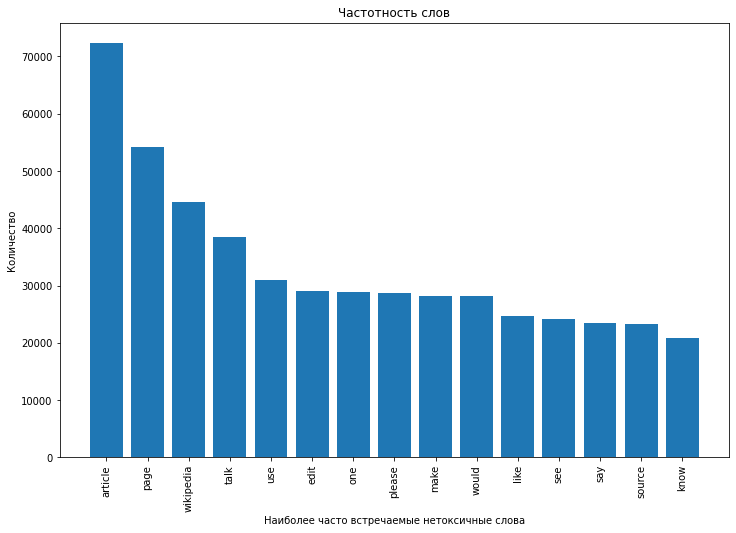

In [15]:

text = str([''.join(string) for string in data[data['toxic'] == 0]['lemm_text']])

text_tokens = word_tokenize(cleaner(text))

fdist = FreqDist(text_tokens)

top_words = fdist.most_common(15)

word_for_plot = {}

for i in top_words:
    word_for_plot[i[0]] = i[1]


plt.title('Частотность слов')
plt.xlabel('Наиболее часто встречаемые нетоксичные слова')
plt.xticks(rotation=90)
plt.ylabel('Количество')

plt.bar(word_for_plot.keys(), word_for_plot.values())

plt.show()

Как видно из графиков, в токсичных твитах чаще встречаются оскорбительные слова.

Интересно, что "wikipedia" примерно одинаково часто встречается и в токсичных, и в нетоксичных твитах.


In [16]:
data[data['lemm_text'] == '']

,text,toxic,lemm_text
2091,"No, it doesn´t.80.228.65.162",0,
2400,"Here, here and here.",0,
3983,From here\n\nFrom here 160.80.2.8,0,
4475,1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n\n1999\n\n2000\n\n2001\n\n2002\n\n2003,0,
6293,193.61.111.53 15:00,0,
...,...,...,...
148751,she did 76.122.79.82,0,
151263,10 - 2010 04 08 to 2010 05 12,0,
152700,SAME FOR THIS 166.137.240.20,0,
153198,which is OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 9000 OVER 90...,0,


In [17]:
data[data['lemm_text'] == '']['toxic'].value_counts(normalize=True)

0    0.983871
1    0.016129
Name: toxic, dtype: float64

In [18]:
from wordcloud import WordCloud
from PIL import Image, ImageDraw


In [19]:
text = str([''.join(string) for string in data['lemm_text']])

text_tokens = word_tokenize(cleaner(text))

text_raw = " ".join(text_tokens)

Выведем облако тегов для датасета.

In [20]:
meta_mask = np.array(Image.open('./tweet.png'))

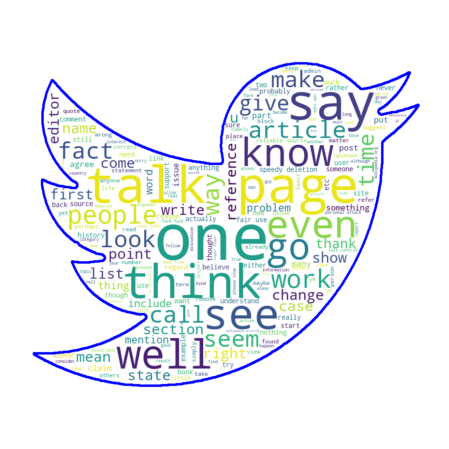

<Figure size 1440x1440 with 0 Axes>

In [21]:
wordcloud = WordCloud(
    background_color='white',
    mask = meta_mask, 
    contour_width = 7,
    contour_color = 'blue'
).generate(text_raw)

im = Image.new("RGB", (0, 0))
draw = ImageDraw.Draw(im)
box_size = draw.textbbox((0, 0), text_raw)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure(figsize=(20, 20))
plt.show();

Проверим на дубликаты после обработки.

In [22]:
data[['lemm_text', 'toxic']].duplicated().sum()

1898

После обработки и лемматизации появились дубликаты.  
Уберем их.

In [23]:
data.drop_duplicates(subset=['lemm_text', 'toxic'], inplace=True)

data.shape

(157394, 3)

Поищем короткие и длинные комментарии.  
Для этого введем столбец с количеством слов в твите.

In [24]:
data['len'] = data['lemm_text'].apply(lambda x: len(x.split()))

In [25]:
data.sort_values(by='len').head(30)

,text,toxic,lemm_text,len
2091,"No, it doesn´t.80.228.65.162",0,,0
119123,"""""""",1,,0
109472,"No, you have to prove that I can't.",0,prove,1
19150,You are more than welcome to do it yourself.,0,welcome,1
50630,Testing. 220.255.2.139,0,test,1
29133,", and I'm not biting.",0,biting,1
57311,Your point being? 86.173.139.210,0,point,1
112907,o no all these bastardsllpaybad,1,bastardsllpaybad,1
117893,Just disregard this all.,0,disregard,1
78613,I will look into what to do about this.,0,look,1


In [26]:
print('Строк с длиной 1 или 0 слов:', data.query('len <= 0').shape[0])

Строк с длиной 1 или 0 слов: 2


58 строк, лемматизированных в одно слово. Думаю, можно безболезненно удалить.

In [27]:
data = data.query('len > 0')

data.shape

(157392, 4)

Посмотрим с другого конца датасета

In [28]:
data.sort_values(by='len', ascending=False).head(30)

,text,toxic,lemm_text,len
32114,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG ...,1,pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig pig ...,1250
76542,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG ...,1,die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag die fag ...,1250
149925,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL ...,0,lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol lol ...,1250
61746,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES ...,0,oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh no oh...,1250
153236,FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW ...,1,fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew ...,1247
32371,THAT WAS REALLY MILLESECONDS WASNT IT BITCH \n\nFAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW ...,1,really milleseconds wasnt bitch fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew fat jew ...,1235
106871,hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron

Множество повторов внутри лемматизированных текстов. Оставим только уникальные значения в порядке следования в оригинальном твите

In [29]:
data['lemm_text'] = data['lemm_text'].apply(lambda x: ' '.join(sorted(set(x.split()), key=x.split().index)))

data.sort_values(by='len', ascending=False).head(30)

,text,toxic,lemm_text,len
32114,PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG PIG ...,1,pig,1250
76542,DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG DIE FAG ...,1,die fag,1250
149925,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL ...,0,lol,1250
61746,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES ...,0,oh no,1250
153236,FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW ...,1,fat jew jewfat,1247
32371,THAT WAS REALLY MILLESECONDS WASNT IT BITCH \n\nFAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW FAT JEW ...,1,really milleseconds wasnt bitch fat jew jewfat,1235
106871,hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron hi moron...,1,hi moron moronhi,1078
6564,Sex sex sex sex Sex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex sex sexSex sex se...,1,sex sexsex,1001
101685,SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER ...,1,super gay,1000
38030,Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark Bark B...,1,bark,1000


Добавим столбец с пересчитанным количеством слов после сокращения лемматизированного текста

In [30]:
data['len_lemmed'] = data['lemm_text'].apply(lambda x: len(x.split()))

In [31]:
data.reset_index(inplace=True)


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157392 entries, 0 to 157391
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   index       157392 non-null  int64 
 1   text        157392 non-null  object
 2   toxic       157392 non-null  int64 
 3   lemm_text   157392 non-null  object
 4   len         157392 non-null  int64 
 5   len_lemmed  157392 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 7.2+ MB


## Краткий вывод

Данные представляют собой размеченный датасет из ~160 тыс. комментариев и отметки токсичности.

Данные загружены, очищены от не-латинских символов, приведены к нижнему регистру и лемматизированы.

После обработки проведена повторная проверка на дубликаты, которые были удалены из датасета.  
По итогу осталось почти 158 тыс. строк.

## Подготовка данных к обучению моделей

Разобьем набор данных на обучающую и тестовую выборки.

In [34]:
X = data['lemm_text'] #.values.astype('U')
y = data['toxic']

X_train, X_test, y_train, y_test = train_test_split(
                X, 
                y, 
                train_size=.8, 
                shuffle=True,
                stratify=y, 
                random_state=RS
            )


print('Размеры выборок:')
print(f'Обучающая выборка: {X_train.shape[0]} строк')
print(f'Тестовая выборка: {X_test.shape[0]} строк')
print(f"Соотношение: ",
    f"{round(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100, 2)} :",
    f"{round(X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]) * 100, 2)}")

#print(f'Количество признаков: {X_train.shape}')

Размеры выборок:
Обучающая выборка: 125913 строк
Тестовая выборка: 31479 строк
Соотношение:  80.0 : 20.0


## Обучение

Оценим качество моделей логистической регрессии, случайного леса и LGBM.

### LogisticRegression

In [36]:
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=list(stops))),
    ('model', LogisticRegression(class_weight='balanced', random_state=RS))
])


LR_parameters = {'tfidf__min_df': [1, 3, 10],
                 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'model__C': [1, 5, 10],
                 'model__solver': ["liblinear", "saga"],

                }

LR_grid = GridSearchCV(
    pipe, 
    param_grid=LR_parameters,
    scoring='f1',
    cv=5,
    error_score='raise'
)

LR_grid.fit(X_train, y_train)

best_f1_LR = LR_grid.best_score_
best_params_LR = LR_grid.best_params_

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [37]:
print('F1:', best_f1_LR) 
print('Parameters:', best_params_LR)

best_LR_model = LR_grid.best_estimator_

F1: 0.7782424165477312
Parameters: {'model__C': 10, 'model__solver': 'saga', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


### RandomForest

Лес страшно запускать - итак три часа учился, с добавлением tf-idf вообще умрет от старости, думаю :(  
Да и метрика все равно унылая, сомнительно, что поднимет ее в полтора раза

In [40]:
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=list(stops))),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=RS))
])


RF_parameters = {'tfidf__min_df': [1, 3, 10],
                 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'model__max_depth': [40, 60],
                 'model__n_estimators': [600, 1000],

                }

RF_grid = GridSearchCV(
    pipe, 
    param_grid=RF_parameters,
    scoring='f1',
    cv=5,
    error_score='raise'
)

RF_grid.fit(X_train, y_train)

best_f1_RF = RF_grid.best_score_
best_params_RF = RF_grid.best_params_

best_RF_model = RF_grid.best_estimator_

KeyboardInterrupt: 

In [43]:
# print('F1:',best_f1_RF) 
# print('Parameters:', best_params_RF)

best_f1_RF = 0
best_params_RF = {}

Хотелось бы подобрать гиперпараметры с помощью Optuna, но учится крайне долго (

Вместо леса потестируем Passive Aggressive Algorithm

In [44]:
from sklearn.linear_model import PassiveAggressiveClassifier


pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=list(stops))),
    ('model', PassiveAggressiveClassifier(class_weight='balanced', random_state=RS, n_jobs=-1))
])


PAC_parameters = {'tfidf__min_df': [1, 3, 10],
                 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'model__max_iter': [50, 100],
                 'model__C': [1, 5, 10],

                }

PAC_grid = GridSearchCV(
    pipe, 
    param_grid=PAC_parameters,
    scoring='f1',
    cv=5,
    error_score='raise'
)

PAC_grid.fit(X_train, y_train)

best_f1_PAC = PAC_grid.best_score_
best_params_PAC = PAC_grid.best_params_

best_PAC_model = PAC_grid.best_estimator_

c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improv

In [45]:
print('F1:', best_f1_PAC) 
print('Parameters:', best_params_PAC)

F1: 0.773928520617828
Parameters: {'model__C': 1, 'model__max_iter': 50, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


### LGBMClassifier

Аналогично остальным моделям, гиперпараметры с помощью Optuna подбирать оч долго :((

In [47]:
pipe = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=list(stops))),
    ('model', LGBMClassifier(learning_rate=0.1, class_weight='balanced', random_state=RS, n_jobs=-1))
])


LGBM_parameters = {'tfidf__min_df': [1, 3, 10],
                 'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'model__max_depth': [50, 100],
                 'model__n_estimators': [600, 1000]

                }

LGBM_grid = GridSearchCV(
    pipe, 
    param_grid=LGBM_parameters,
    scoring='f1',
    cv=5,
    error_score='raise'
)

LGBM_grid.fit(X_train, y_train)

best_f1_LGBM = LGBM_grid.best_score_
best_params_LGBM = LGBM_grid.best_params_

best_LGBM_model = LGBM_grid.best_estimator_

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10230, number of negative: 90500
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.901799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 466982
[LightGBM] [Info] Number of data points in the train set: 100730, number of used features: 8667
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leave

In [48]:
print('F1:', best_f1_LGBM) 
print('Parameters:', best_params_LGBM)

F1: 0.7645027202071883
Parameters: {'model__max_depth': 50, 'model__n_estimators': 1000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [49]:
result = pd.DataFrame([[best_f1_LR, best_f1_PAC, best_f1_LGBM]],
                       index=['F1-score'], 
                       columns=['LogisticRegresion', 'PassiveAgressive', 'LGBM']
                       )

result

,LogisticRegresion,PassiveAgressive,LGBM
F1-score,0.778242,0.773929,0.764503


## Краткий вывод

Данные разбиты на обучающую и тестовую выборки.

Обучены модели классификации логистической регрессии, случайного леса LGBM.  
Оценка моделей проводилась по метрике F1-score.

С небольшим перевесом максимальный показатель метрики выдала модель логистической регрессии.

### Проверка лучшей модели на тестовой выборке

In [51]:
print('F1 on test (logisticRegression):', f1_score(y_test, best_LR_model.predict(X_test)))

print('F1 on test (PassiveAgressiveClassifier):', f1_score(y_test, best_PAC_model.predict(X_test)))

print('F1 on test (LightGBMClassifier):', f1_score(y_test, best_LGBM_model.predict(X_test)))

F1 on test (logisticRegression): 0.782727687395469
F1 on test (PassiveAgressiveClassifier): 0.7815219110900175
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
F1 on test (LightGBMClassifier): 0.7725242568920377


Поскольку все модели дали приблизительно равный результат, прогнал на тесте их все.  

Победа все равно за Логистической регрессией!

In [52]:
features = best_LR_model[0].get_feature_names_out().tolist()
coefs = best_LR_model[1].coef_.tolist()[0]

weights = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'Coef']).sort_values(by='Coef',ascending=False).head(20)
weights

,Feature,Coef
645564,fuck,54.876074
1470729,shit,33.297263
769922,idiot,32.948098
1568604,stupid,31.235657
1576148,suck,27.138583
124514,asshole,25.466890
223408,bullshit,24.349471
189248,bitch,24.329278
1040362,moron,22.490647
374077,crap,22.484031


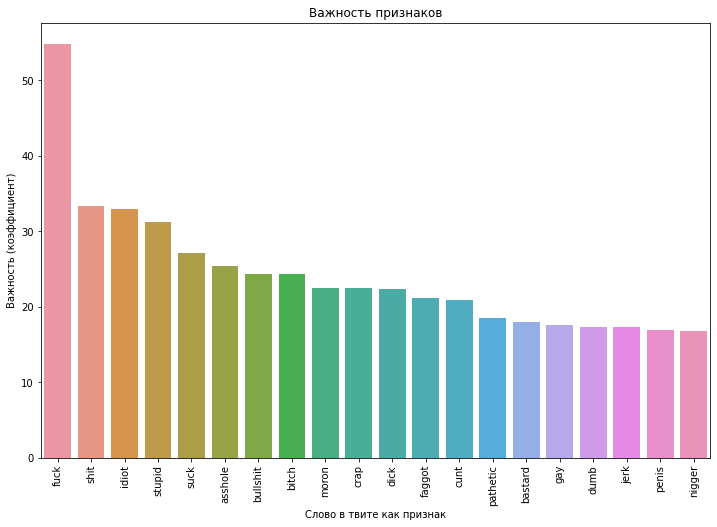

In [53]:
sns.barplot(x=weights['Feature'], y=weights['Coef'])

plt.xlabel('Слово в твите как признак')
plt.ylabel('Важность (коэффициент)')
plt.xticks(rotation=90)


plt.title('Важность признаков');


Заметим, что Википедия пропала из списка важных для модели слов :)  
В остальном - график говорит сам за себя.

# BERT

Попробуем использовать нейронную сеть BERT.



In [54]:
# Заново загрузим данные, так как лемматизация и очистка текста проходят внутри Берты
pth1 = 'D:\Temp\Ya_Pr\toxic_comments.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0])
elif not os.path.exists(pth1):
    data = pd.read_csv('https://code.s3.yandex.net//datasets//toxic_comments.csv', index_col=[0])
else:
    print('Something is wrong')


# Возьмем 5000 строк, дабы не ждать слишком долго
data_small = data.sample(5000, random_state=RS).reset_index(drop=True)

In [55]:
data_small = data_small[data_small['text'].str.len() < 512]

data_small.shape

(3949, 2)

In [56]:
# Отрежем еще чуть-чуть, чтобы было кратно размеру батча
data_small = data_small[:3900]

In [57]:
config = transformers.BertConfig.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = data_small['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [59]:
padded.shape

(3900, 192)

In [60]:
batch_size = 300

# Кстати, размер батча ограничивается исключительно мощнотями доступными? 

embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/13 [00:00<?, ?it/s]

In [61]:
features = np.concatenate(embeddings)
target = data_small['toxic']

X_train, X_test, y_train, y_test = train_test_split(
                features, 
                target, 
                train_size=.8, 
                shuffle=True,
                stratify=target, 
                random_state=RS
            )


In [62]:

LR_bert_arameters = {'C': [1, 5, 10],
                 'solver': ["liblinear", "saga"],
                 'penalty': ['l1', 'l2']

                }

LR_bert = LogisticRegression(random_state=RS)


LR_bert_grid = GridSearchCV(
    LR_bert, 
    param_grid=LR_bert_arameters,
    scoring='f1',
    cv=5,
    error_score='raise'
)

LR_bert_grid.fit(X_train, y_train)

best_f1_LR_bert = LR_bert_grid.best_score_
best_params_LR_bert = LR_bert_grid.best_params_

best_LR_bert = LR_bert_grid.best_estimator_


c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\apple\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
result['Bert'] = best_f1_LR_bert

result

,LogisticRegresion,PassiveAgressive,LGBM,Bert
F1-score,0.778242,0.773929,0.764503,0.956827


In [64]:
preds = best_LR_bert.predict(X_test)

print('F1 (BERT):', f1_score(y_test, preds))


F1 (BERT): 0.9206349206349206


### Краткий вывод

BERT показала себя заметно лучше классических моделей (F1-score = 0.92).

P.S. Он реально настолько круче!

## Выводы

По исходным данным (датасет из ~160 тыс. комментариев и отметки токсичности) необходимо разработать модель оценки токсичности комментария.  
Необходимо достичь показателя метрики F1-score не менее 0,75.

Для решения задачи данные загружены, очищены от не-латинских символов, приведены к нижнему регистру и лемматизированы.

Проведена проверка на дубликаты, которые были удалены из датасета.  
По итогу осталось почти 158 тыс. строк.

Данные разбиты на обучающую и тестовую выборки в оотношении 5:1; подготовлен пайплайн для обучения моделей с помощью tf-idf-векторизации.

Обучены модели классификации логистической регрессии, случайного леса LGBM.  
Оценка моделей проводилась по метрике F1-score.

С небольшим перевесом максимальный показатель метрики выдала модель логистической регрессии.

Лучшая модель проверена на тестовой выборке. Показатель целевой метрики составил 0,778, что удовлетворяет поставленной задаче.

---

Также проведен эксперимент с использованием нейронной сети BERT для поиска токсичных комментариев.  
Она показала заметно лучший результат (0,92).